In [2]:
import numpy as np
from numpy import random as rd
from pykrx import stock

#여러 ETF들 종목코드
#ETF_ticker = ["252670", "122630", "233740", "251340", "114800", "069500", "102110", "225800", "138230", "132030", "280940", "292570", "292590", "292580"]
#14종목을 유니버스로 두는 경우 가중치가 특정 종목에 쏠려서 4종목으로 유니버스 축소
#아래 티커는 각각 kodex레버리지 / KODEX MSCI모멘텀 / kosef미국달러선물 / KODEX 모멘텀PLUS
ETF_ticker = ["122630", "275280", "138230", "244620"]
N = len(ETF_ticker) #ETF 갯수만큼 자산 총 갯수는 N개로 제한된다.
stocks_data = []
srt = "20140101"
end = "20191231"
for i in range(0, N):
    stocks_data.append(stock.get_market_ohlcv_by_date(srt, end, ETF_ticker[i])["종가"][-300:])#룩백윈도우는 300일


In [3]:
np.var(stocks_data[0])
np.cov(stocks_data[0], stocks_data[0])
#numpy에서 var는 biased estimator, cov는 unbiased를 사용함.

array([[768600.45819398, 768600.45819398],
       [768600.45819398, 768600.45819398]])

In [4]:
arr123 = [3,5,10,7,4,1,2]
np.var(arr123, ddof=1)
#var method에서 ddof=1로 설정하면 unbiased estimator를 사용함

9.619047619047619

In [5]:
np.cov(arr123, arr123)#, bias=True)

array([[9.61904762, 9.61904762],
       [9.61904762, 9.61904762]])

In [6]:
#var - cov matrix 생성
def getCov(a, b):
    return np.cov(a,b)

var_cov_mat = np.identity(N) # N * N 단위행렬

for i in range(0, N):
    for j in range(0, N):
        var_cov_mat[i][j] = getCov(stocks_data[i], stocks_data[j])[0,1]

In [7]:
import pandas as pd
df = pd.DataFrame(var_cov_mat)
df #var cov matrix를 살펴봅니다

,0,1,2,3
0,768600.458194,196003.595318,-101183.123746,202043.399331
1,196003.595318,125679.129320,-115309.425864,144233.040134
2,-101183.123746,-115309.425864,153888.159420,-116942.705017
3,202043.399331,144233.040134,-116942.705017,252306.451773


In [8]:
con = 0 # 몬테카를로 조건을 만족한 For문 횟수
minloss = []

#몬테카를로에서 30만이라는 값은 0 <= w_i <= 1, sum(w) = 1, i = 1,2,3,4 를 만족하는 R^4 공간에 비교하면 작은 값이라 생각됨.
for i in range(300000): 
    # sum(w) = 1 를 만족하는 w 생성
    w = []
    wmax = 100
    wadded = 0
    for i in range(0, N): #sum(w) = 1 을 만족하는 무작위 가중치 벡터 생성
        added = rd.randint(0, wmax-wadded+1)
        wadded += added
        if i == N-1 and np.sum(w) != 100:
            added = round((1 - np.sum(w))*100,3)
        w.append(added/100)


    if np.round(np.sum(w),3) == 1:
        con+=1

    #생성된 weight vector를 통해 minimize문제 풀기
    risk = np.dot(np.dot(np.transpose(w), var_cov_mat), w) # sigma _ w
    sigma_and_w = np.dot(var_cov_mat, w)
    
    lossfunc = 0
    for i in range(0, N):
        lossfunc += (w[i] - risk**2/(sigma_and_w[i] * N))**2
    minloss.append((lossfunc, w)) #가장 작은 lossfunc 값을 생성하는 가중치 벡터 w를 저장
print(min(minloss))
print(con)
#

(21737353.42821542, [0.0, 0.52, 0.47, 0.01])
300000


In [40]:
import scipy as sp
from scipy import optimize
def eq_constraint(w):
    summation = 0
    for i in w:
        summation += i
    return summation -1

w_init = [1/N for i in range(0,N)]


def flarray(w):
    summation = 0
    N = len(w)
    for wi, i in zip(w, range(0,N)):
        summation += (wi - risk/(N* np.array(np.dot(var_cov_mat, w)[i])))**2
    return summation


In [44]:
sp.optimize.fmin_slsqp(flarray, np.array([0.25, 0.25, 0.25, 0.25]), eqcons=[eq_constraint])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19002280581990166
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7


array([0.25211862, 0.393922  , 0.01577513, 0.33818425])

In [8]:
ret = pd.DataFrame(np.nan,index=np.arange(len(stocks_data[0])), columns=ETF_ticker)
for stock, idx in zip(ETF_ticker, range(0,N)): #수익률을 구해줍니다. 컬럼을 누적해서 곱하면 누적수익률이 됨.
    for i in range(1, len(stocks_data[0])):
        ret[stock].iloc[i] =  stocks_data[idx][i]/stocks_data[idx][i-1] 

In [9]:
ret #return 값을 살펴봅니다.

,122630,275280,138230,244620
0,NaN,NaN,NaN,NaN
1,0.996033,0.994170,0.994454,1.012081
2,1.025090,1.012815,0.997855,1.012940
3,0.981352,0.988419,1.007309,0.985245
4,1.007918,1.013343,0.997866,1.007940
...,...,...,...,...
295,0.998586,1.000000,1.002852,0.997768
296,0.986195,0.992563,0.999594,0.997204
297,1.008256,0.994813,0.998374,1.017386
298,1.031328,1.028969,0.999593,1.020397


In [10]:
asdf = [1,2,3,4]
fdsa = [2,3,4,5]
kkkk = [10,10,10,10]
np.sum((asdf,fdsa,kkkk), axis=0)
#이런식으로 sum함수에 axis=0을 붙여주면 선형결합을 함

array([13, 15, 17, 19])

In [11]:
#EW는 equal weight, 각 자산에 초기에 1/N씩 투자하는 포트폴리오임(리밸런싱 아직 구현 못함)
s = [1/N for i in range(0,N)]
ew = np.sum((ret[stock]*i for stock, i in zip(ETF_ticker, s)))
ew

/Users/yongcheolkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0           NaN
1      0.999185
2      1.012175
3      0.990581
4      1.006767
         ...   
295    0.999802
296    0.993889
297    1.004707
298    1.020072
299    1.000091
Length: 300, dtype: float64

In [12]:
#ERC는 앞서 10번 블럭에서 구한 w값을 통해 각 자산의 비중을 결정함.
erc = np.sum((ret[stock]*w[i] for stock, i in zip(ETF_ticker, range(0,N))), axis=0)
erc

/Users/yongcheolkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


0           NaN
1      0.997440
2      1.020045
3      0.983987
4      1.009285
         ...   
295    0.998912
296    0.989369
297    1.005623
298    1.029062
299    0.998712
Length: 300, dtype: float64

In [13]:
for i, j in zip(range(1,10), range(11,20)):
    print(i,j)
#이런식으로 하나의 for문에 2개의 index를 사용할 수 있음.

1 11
2 12
3 13
4 14
5 15
6 16
7 17
8 18
9 19


In [14]:
np.cumprod([1,2,3,4,5,6,7,8,9,10])
#cumsum : 누적 합계
#cumprod : 누적 곱

array([      1,       2,       6,      24,     120,     720,    5040,
         40320,  362880, 3628800])

In [15]:
ew_cum = np.cumprod(ew)
erc_cum = np.cumprod(erc)
#누적수익률을 구해줍니다

In [16]:
ew_cum #동일비중 포트폴리오의 누적수익률

0           NaN
1      0.999185
2      1.011350
3      1.001824
4      1.008603
         ...   
295    1.012037
296    1.005852
297    1.010587
298    1.030871
299    1.030965
Length: 300, dtype: float64

In [17]:
erc_cum #ERC 포트폴리오의 누적수익률

0           NaN
1      0.997440
2      1.017434
3      1.001142
4      1.010437
         ...   
295    1.048720
296    1.037572
297    1.043406
298    1.073729
299    1.072346
Length: 300, dtype: float64

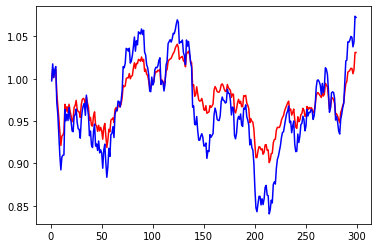

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(ew_cum,'r')#동일비중포트폴리오 - 빨강
plt.plot(erc_cum,'b')#ERC포트폴리오 - 파랑
plt.show()
#왜 ERC의 MDD가 더 큰지 나도 모르겠다.